# This notebook examines state-specific trends in the processed general.txt file (general.pkl)

In [1]:
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import pickle
import os
import re
import cpi

processed_path = '/data/ihwang/data_journalism/allfac/processed/'
df_general = pd.read_pickle(processed_path + 'general.pkl')

# Agency prefix dictionary:
with open(processed_path + 'agency_dict.pkl', 'rb') as f_r:
    agency_dict = pickle.load(f_r)
# Entity code dictionary:
with open(processed_path + 'entity_dict.pkl', 'rb') as f_r:
    entity_dict = pickle.load(f_r)

Fields carried over from processing general.txt

In [2]:
# for i in df_general.columns:
#     print(i)

Adjust `DOLLARTHRESHOLD` and `TOTFEDEXPEND_ADJUSTED` for inflation

In [3]:
df_general['DOLLARTHRESHOLD_ADJUSTED'] = df_general.apply(lambda x: cpi.inflate(x.DOLLARTHRESHOLD, x.AUDITYEAR), axis=1)
df_general['TOTFEDEXPEND_ADJUSTED'] = df_general.apply(lambda x: cpi.inflate(x.TOTFEDEXPEND, x.AUDITYEAR), axis=1)

Remove territories/islands

In [4]:
df_analysis = df_general[~df_general['STATE'].isin(['AS','MP','FM','PR','GU','PW','MH','VI'])]

Define 2D plotting function

In [5]:
def plot_2d(series_dict1, series1, series_dict2, series2):
    fig, axes = plt.subplots(figsize=(5, 5))
    df_plot = pd.concat(
        [series_dict1[series1].rename(series1), series_dict2[series2].rename(series2)], 
        axis=1, sort=True
    )
    axes_max = max(max(series_dict1[series1]), max(series_dict2[series2]))
    df_plot.dropna(inplace=True)
    plot = df_plot.plot(
        x=series1, y=series2, kind='scatter', fontsize=16, ax=axes
    )
    for i, point in df_plot.iterrows():
        axes.text(point[series1], point[series2], str(i))
    plot.set_xlabel(series1, fontsize=16, fontname='Arial')
    plot.set_ylabel(series2, fontsize=16, fontname='Arial')
    plot.set_ylim(bottom=0, top=1.1*axes_max)
    plot.set_xlim(left=0, right=1.1*axes_max)
    axes.plot(axes.get_xlim(), axes.get_ylim(), ls="--", c=".3")
    plt.tight_layout()
    plt.show()
    return df_plot

## Calculate relative numbers of audits and total expenditure

In [6]:
series_state_pct_audits = 100 * df_analysis.groupby('STATE').size().sort_values(ascending=False) / len(df_analysis)
series_dict = {'PCT_ALL_AUDITS': series_state_pct_audits}
series_state_pct_fedexpend = 100 * df_analysis.groupby('STATE')\
    ['TOTFEDEXPEND_ADJUSTED'].sum().sort_values(ascending=False) / \
    df_analysis['TOTFEDEXPEND_ADJUSTED'].sum() 
series_dict['PCT_FEDEXPEND'] = series_state_pct_fedexpend

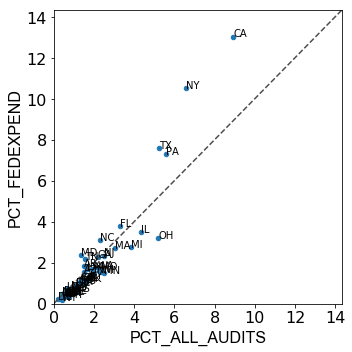

Total number of audits: 831431
Total in federal funding (adjusted): 2.48354464896e+13


In [7]:
df_plot = plot_2d(series_dict, 'PCT_ALL_AUDITS',series_dict, 'PCT_FEDEXPEND')
print('Total number of audits: %s' %len(df_analysis))
print('Total in federal funding (adjusted): %s' %df_analysis['TOTFEDEXPEND_ADJUSTED'].sum())

## Risk

In [8]:
df_risk_state = df_analysis.groupby('STATE')['LOWRISK'].value_counts().sort_index().unstack()
series_risk_state_norm = 100 * df_risk_state['N'] / len(df_analysis[df_analysis['LOWRISK'] == 'N'])
series_dict['PCT_HIGH_RISK'] = series_risk_state_norm

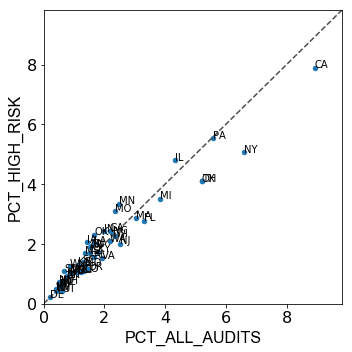

In [9]:
df_plot = plot_2d(series_dict, 'PCT_ALL_AUDITS', series_dict, 'PCT_HIGH_RISK')

In [10]:
df_analysis[df_analysis['LOWRISK'] == 'N']['TOTFEDEXPEND_ADJUSTED'].sum()

17324946078521.369

## Financial statements

What are the possible bases of accounting that can be used?

In [11]:
set(df_analysis['SP_FRAMEWORK'])

{'', 'CASH', 'CONTRACTUAL', 'OTHER', 'REGULATORY', 'TAX'}

Filter data based on a particular basis of accounting framework

In [12]:
framework = 'TAX'
df_financial = df_analysis[df_analysis['SP_FRAMEWORK'] == framework]

if framework == '':
    framework_str = 'GAAP'
else:
    framework_str = framework
print('Number of audits prepared according to a %s framework: %s' %(framework_str, len(df_financial)))
print('Total in federal funding (adjusted): %s' %df_financial['TOTFEDEXPEND_ADJUSTED'].sum())

Number of audits prepared according to a TAX framework: 7
Total in federal funding (adjusted): 22669234.2764


Filter by whether special framework was required by state law (only for special purpose frameworks)

In [13]:
# if framework != '':
#     df_financial_required = df_financial[df_financial['SP_FRAMEWORK_REQUIRED'] == 'Y']
#     print('Of the %s audits prepared according to a %s framework, %s were required to use the framework under state law' 
#           %(len(df_financial), framework_str, len(df_financial_required)))

Note that after both filtering steps, the following plots will contain information along the lines of: "California accounts for X% of all audits prepared according to GAAP, but accounts for Y% of all audits prepared according to GAAP with at least one material noncompliance."

In [14]:
fs_series_dict = {}
###############################################################################
# Calculate general numbers: percent of all audits and total expenditure
###############################################################################
series_state_pct_audits = 100 * \
    df_financial.groupby('STATE').size() / \
    len(df_financial)
if framework == '':
    key_framework = 'GAAP'
else:
    key_framework = framework
fs_series_dict['PCT_%s_FRAMEWORK' %key_framework] = series_state_pct_audits
series_state_pct_fedexpend = 100 * \
    df_financial.groupby('STATE')['TOTFEDEXPEND_ADJUSTED'].sum() / \
    df_financial['TOTFEDEXPEND_ADJUSTED'].sum()
fs_series_dict['PCT_FEDEXPEND'] = series_state_pct_fedexpend
###############################################################################

###############################################################################
# Get percent of A/D audit opinions on financial statement preparation and 
# financial issues
###############################################################################
if framework == '':
    sortby_fs = 'TYPEREPORT_FS'
else:
    sortby_fs = 'TYPEREPORT_SP_FRAMEWORK'
ad_op_list = [
    i for i in set(df_financial[sortby_fs]) 
    if ('A' in i) or ('D' in i)
]
df_state_fs = df_financial.groupby('STATE')\
    [sortby_fs].value_counts().unstack()
series_state_ad_fs_norm = 100 * \
               df_state_fs[ad_op_list].sum(axis=1) / \
               len(df_financial[df_financial[sortby_fs].isin(ad_op_list)])
fs_series_dict[
    'PCT_AD_%s' %sortby_fs
] = series_state_ad_fs_norm

# Get percent of financial issues
for sortby_fs in [
    'GOINGCONCERN','REPORTABLECONDITION', 'MATERIALWEAKNESS',
    'MATERIALNONCOMPLIANCE'
]:
    df_state_op = df_financial.groupby('STATE')[sortby_fs].value_counts().sort_index().unstack()
    if set(df_financial[sortby_fs]) != set(['Y','N']):
        count_cols = [
            i for i in set(df_financial[sortby_fs]) if (i != 'N') and (i != '')
        ]
    else:
        count_cols = ['Y']
    series_state_op_norm = 100 * \
        df_state_op[count_cols].sum(axis=1) / \
        len(df_financial[df_financial[sortby_fs].isin(count_cols)])
    fs_series_dict_key = 'PCT_GEQ1_%s' %sortby_fs
    fs_series_dict[fs_series_dict_key] = series_state_op_norm
##############################################################################

print(fs_series_dict.keys())

dict_keys(['PCT_TAX_FRAMEWORK', 'PCT_FEDEXPEND', 'PCT_AD_TYPEREPORT_SP_FRAMEWORK', 'PCT_GEQ1_GOINGCONCERN', 'PCT_GEQ1_REPORTABLECONDITION', 'PCT_GEQ1_MATERIALWEAKNESS', 'PCT_GEQ1_MATERIALNONCOMPLIANCE'])


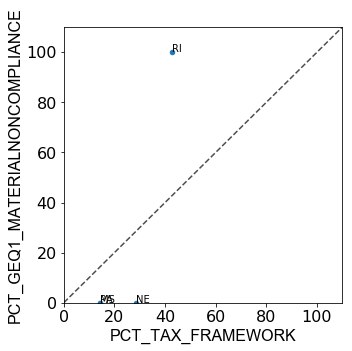

In [16]:
df_plot = plot_2d(fs_series_dict, 'PCT_TAX_FRAMEWORK', fs_series_dict, 'PCT_GEQ1_MATERIALNONCOMPLIANCE')

In [17]:
# df_plot.sort_values('PCT_GEQ1_MATERIALNONCOMPLIANCE', ascending=False)

In [18]:
# df_plot.sort_values('PCT_GEQ1_MATERIALNONCOMPLIANCE', ascending=False)
# df_plot[df_plot['PCT_GEQ1_REPORTABLECONDITION'] >= 3*df_plot['PCT_FEDEXPEND']]

sortby_fs = 'MATERIALNONCOMPLIANCE'
# if (sortby_fs != 'TYPEREPORT_SP_FRAMEWORK') & (sortby_fs != 'TYPEREPORT_FS'):
#     count_cols = [
#                 i for i in set(df_financial[sortby_fs]) if (i != 'N') and (i != '')
#             ]
#     print(len(df_financial[df_financial[sortby_fs].isin(count_cols)]))
#     print(df_financial[df_financial[sortby_fs].isin(count_cols)]['TOTFEDEXPEND_ADJUSTED'].sum())
# else:
#     print(len(df_financial[df_financial[sortby_fs].str.contains('A|D', regex=True)]))
#     print(df_financial[df_financial[sortby_fs].str.contains('A|D', regex=True)]['TOTFEDEXPEND_ADJUSTED'].sum())

state = 'OH'
print(len(df_financial[df_financial['STATE'] == state]))
print(df_financial[df_financial['STATE'] == state]['TOTFEDEXPEND_ADJUSTED'].sum())

# print(len(df_financial[(df_financial[sortby_fs].str.contains('A|D', regex=True)) & (df_financial['STATE'] == state)]))
# print(df_financial[(df_financial[sortby_fs].str.contains('A|D', regex=True)) & (df_financial['STATE'] == state)]['TOTFEDEXPEND_ADJUSTED'].sum())

print(len(df_financial[(df_financial['STATE'] == state) & (df_financial[sortby_fs] != 'N')]))
print(df_financial[(df_financial['STATE'] == state) & (df_financial[sortby_fs] != 'N')]['TOTFEDEXPEND_ADJUSTED'].sum())

# df_financial[
#     (df_financial['STATE'] == state) & \
#     (df_financial['TYPEREPORT_FS'].str.contains('A|D', regex=True))
# #     (df_financial['GOINGCONCERN'] != 'N')
# # #     (df_financial['MATERIALWEAKNESS'] != 'N')
# # #     (df_financial['MATERIALNONCOMPLIANCE'] != 'N')
# # #     (df_financial['REPORTABLECONDITION'] != 'N')
# ]['TYPEOFENTITY'].value_counts()
# ].groupby('TYPEOFENTITY')['TOTFEDEXPEND_ADJUSTED'].sum().sort_values(ascending=False)

0
0.0
0
0.0


## Program compliance

In [19]:
mp_series_dict = {}
###############################################################################
# Get percent of A/D audit opinions on major program compliance and program
# compliance issues
###############################################################################
sortby_mp = 'TYPEREPORT_MP'
ad_op_list = [
    i for i in set(df_analysis[sortby_mp]) 
    if ('A' in i) or ('D' in i)
]
df_state_fs = df_analysis.groupby('STATE')\
    [sortby_mp].value_counts().unstack()
series_state_ad_fs_norm = 100 * \
               df_state_fs[ad_op_list].sum(axis=1) / \
               len(df_analysis[df_analysis[sortby_mp].isin(ad_op_list)])
mp_series_dict[
    'PCT_AD_%s' %sortby_mp
] = series_state_ad_fs_norm

# Get percent of financial issues
for sortby_mp in [
    'REPORTABLECONDITION_MP', 'MATERIALWEAKNESS_MP', 'QCOSTS'
]:
    df_state_op = df_analysis.groupby('STATE')[sortby_mp].value_counts().sort_index().unstack()
    if set(df_analysis[sortby_mp]) != set(['Y','N']):
        count_cols = [
            i for i in set(df_analysis[sortby_mp]) if (i != 'N') and (i != '')
        ]
    else:
        count_cols = ['Y']
    series_state_op_norm = 100 * \
        df_state_op[count_cols].sum(axis=1) / \
        len(df_analysis[df_analysis[sortby_mp].isin(count_cols)])
    mp_series_dict_key = 'PCT_GEQ1_%s' %sortby_mp
    mp_series_dict[mp_series_dict_key] = series_state_op_norm
##############################################################################

print(mp_series_dict.keys())

dict_keys(['PCT_AD_TYPEREPORT_MP', 'PCT_GEQ1_REPORTABLECONDITION_MP', 'PCT_GEQ1_MATERIALWEAKNESS_MP', 'PCT_GEQ1_QCOSTS'])


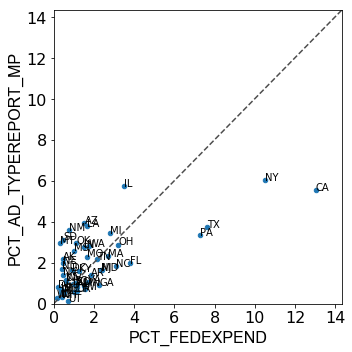

In [23]:
df_plot = plot_2d(series_dict, 'PCT_FEDEXPEND', mp_series_dict, 'PCT_AD_TYPEREPORT_MP')

In [22]:
# df_plot.sort_values('PCT_AD_TYPEREPORT_MP', ascending=False)

In [34]:
# print(len(df_analysis[df_analysis['TYPEREPORT_MP'].str.contains('A|D', regex=True)]))
# print(df_analysis[df_analysis['TYPEREPORT_MP'].str.contains('A|D', regex=True)]['TOTFEDEXPEND_ADJUSTED'].sum())

state = 'NY'
print(len(df_analysis[df_analysis['STATE'] == state]))
print(df_analysis[df_analysis['STATE'] == state]['TOTFEDEXPEND_ADJUSTED'].sum())

print(len(df_analysis[(df_analysis['TYPEREPORT_MP'].str.contains('A|D', regex=True)) & (df_analysis['STATE'] == state)]))
print(df_analysis[(df_analysis['TYPEREPORT_MP'].str.contains('A|D', regex=True)) & (df_analysis['STATE'] == state)]['TOTFEDEXPEND_ADJUSTED'].sum())





54788
2.61232775589e+12
145
77563195143.9


In [39]:
145/54788

0.0026465649412280062